In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Parameter
from torch.autograd import Variable
import torch.utils.data as data_utils

from math import pi, log
# from BBSVI import SVI

In [2]:
import torch
import numpy as np


class SVI():
    '''Class for black box stochastic variational inference
        https://arxiv.org/abs/1401.0118
    
    '''
    
    def __init__(self, data, prior_distr, var_distr, opt, scheduler=None):
        '''Initialization
        
        Args:
            data: oserved data
            prior_distr: class for prior probabilistic model
                requred methods: log_likelihood_global(beta)
                                 log_likelihood_local(z, beta)
                                 log_likelihood_joint(x, z, beta)
            var_distr: class for variational distribution
                required methods: log_likelihood_global(beta)
                                  log_likelihood_local(z, idx)
                                  sample_global()
                                  sample_local(idx)
            opt: optimizer
            scheduler: scheduler for an optimizer
        
        '''
        
        self.data = data
        self.prior_distr = prior_distr
        self.var_distr = var_distr
        self.opt = opt
        self.scheduler = scheduler      

    def bb1_loss_(self, num_samples, batch_indices):
        '''Computing loss of BB SVI 1
        
        Args:
            num_samples: number of samples used for approximation
            batch_indices: indices of batch
        
        Returns:
            loss: Black Box loss function
        
        '''
        
        global_loss = torch.zeros(1, requires_grad=True)
        local_loss = torch.zeros(1, requires_grad=True)
        
        for i in range(num_samples):
            
            beta = self.var_distr.sample_global()
            global_const_term = torch.zeros(1, requires_grad=False)
            
            for idx in batch_indices:
                x = self.data[idx]
                z = self.var_distr.sample_local(beta, idx)
                
                local_const_term = self.prior_distr.log_likelihood_local(z, beta) + \
                                   self.prior_distr.log_likelihood_joint(x, z, beta) - \
                                   self.var_distr.log_likelihood_local(z, idx)
                
                local_var_term = self.var_distr.log_likelihood_local(z, idx)
                
                local_loss = local_loss + local_var_term * local_const_term.data
                
                global_const_term += self.prior_distr.log_likelihood_local(z, beta) + \
                                     self.prior_distr.log_likelihood_joint(x, z, beta)
            
            global_const_term *= self.data.shape[0] / batch_indices.shape[0]
            global_const_term += self.prior_distr.log_likelihood_global(beta) - \
                                 self.var_distr.log_likelihood_global(beta)
            
            global_var_term = self.var_distr.log_likelihood_global(beta)
            global_loss = global_loss + global_var_term * global_const_term.data
                    
        loss = -(global_loss + local_loss) / num_samples
        
        return loss
    
    def bb2_loss_(self, num_samples, batch_indices):
        '''Computing loss of BB SVI 2, which has lower variance compare to BB SVI 1
        
        Args:
            num_samples: number of samples used for approximation
            batch_indices: indices of batch
        
        Returns:
            loss: Black Box loss function
        
        '''
        
        loss_global = torch.zeros(1, requires_grad=True)
        loss_local = torch.zeros(1, requires_grad=True)
        
        global_samples = [self.var_distr.sample_global() for _ in range(num_samples)]
        a = torch.autograd.grad(self.var_distr.log_likelihood_global(global_samples[0]), 
                                self.var_distr.parameters, 
                                allow_unused=True)
        a = [torch.zeros(1) if x is None else x for x in a]
        
        b = torch.autograd.grad(self.var_distr.log_likelihood_global(global_samples[1]), 
                                self.var_distr.parameters, 
                                allow_unused=True)
        b = [torch.zeros(1) if x is None else x for x in b]
        c = tuple(map(operator.add, a, b))
        print(a)
        print(b)
        print(c)
        raise Exception
        for idx in batch_indices:
            pass

    def make_inference(self, num_steps=100, num_samples=10, batch_size=10, shuffle=False, print_progress=True):
        '''Making SVI
        
        Args:
            num_steps: int, maximum number of epoches
            tol: required tolerance
            num_samples: int, number of samples used for ELBO approximation
            batch_size: int, size of one batch
            shuffle: boolean, if batch is shuffled every epoch or not
            print_progress: boolean, if True then progrss bar is printed
            
        '''
        
        
        for step in range(num_steps):
            
            if shuffle:
                indices = np.random.choice(self.data.shape[0], self.data.shape[0], False)
            else:
                indices = np.arange(self.data.shape[0])
                
            indices = np.split(indices, np.arange(batch_size, self.data.shape[0], batch_size))
                
            for batch_indices in indices:
                self.opt.zero_grad()
                loss = self.bb1_loss_(num_samples, batch_indices)
                loss.backward()
                self.opt.step()

            if print_progress:
                if (int(25 * step / num_steps) != int(25 * (step - 1) / num_steps)):
                    print('.', end='')
        
        if print_progress:
            print()



# Avtoencoder: 

In [31]:
class Encoder(object):
    
    
    def __init__(self, encoder_net, data):
        """
        Initialization
        
        Args:
            
            encoder_net: torch.nn.Network. Should be forward method, that takes data[index] 
                         and returns mu and logsigma
            
            data: data, should be callable by index
        
        """
        
        self.net = encoder_net
        self.data = data
        

        def log_likelihood_global(self, beta):
            
            """
            log ( q ( beta ) )
            """
            
            output = torch.zeros(1)
            
            return output
                                  
        
        def log_likelihood_local(self, z, idx):
            
            """
            log ( q ( z_i | phi_i ) )
            """
            
            mu_idx, logsigma_idx = self.net(data[idx])
            
            mu_idx = torch.nn.Parameter(mu_idx)
            sigma_idx = torch.nn.Parameter(torch.exp(logsigma_idx) ** 2)
            
            
            dist_idx = torch.distributions.Normal(mu_idx, logsigma_idx)
            
            output = dist_idx.log_prob(z)
            
            return output
                                  
        def sample_global(self):
            
            """
            beta
            """
            
            output = torch.zeros(1)
            
            return output
            
        
        def sample_local(self, idx):
        
            """
            log ( q ( z_i | x_i ) )
            """
            
            mu_idx, logsigma_idx = self.net(data[idx])
            
            mu_idx = torch.nn.Parameter(mu_idx)
            sigma_idx = torch.nn.Parameter(torch.exp(logsigma_idx) ** 2)
            
            
            dist_idx = torch.distributions.Normal(mu_idx, logsigma_idx)
            
            output = dist_idx.sample()
                        
            return output
    

In [32]:
class Decoder(object):
    
    def __init__(self, decoder_net):
        
        self.net = decoder_net
    
    def log_likelihood_global(self, beta):
        """
        log p(beta)
        """
        
        return torch.zeros(beta.shape[0])
                                 
    def log_likelihood_local(self, z, beta):
        """
        log p(z | beta)
        """
        dist = torch.distributions.Normal(0, 1)
        
        output = dist.log_prob(z)
        
        return output
        
        
    def log_likelihood_conditional(self, x, z):
        """
        log (p ( x | z))
        
        """
        
        mu, logsigma = self.net(z)
            
        mu = torch.nn.Parameter(mu_idx)
        sigma = torch.nn.Parameter(torch.exp(logsigma_idx) ** 2)
            
            
        dist = torch.distributions.Normal(mu, logsigma)
            
        output = dist.log_prob(x)
            
        return output
        
    
    def log_likelihood_joint(self, x, z, beta):
        
        """
        log p(x, z | beta) = log p (x | z) + log p(z)
        """
        
        output = log_likelihood_conditional(x, z) + log_likelihood_local(z, beta)
        
        return output

In [9]:
class Encoder_net(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super(Encoder_net, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            
        )
        
        self.mu = nn.Linear(output_size, output_size)
        
        self.sigma = nn.Linear(output_size, output_size)
    
    
    def forward(self, x):
        
        latent_variable = self.encoder(x)
        
        latent_mu = self.mu_h(latent_variable)
        latent_logsigma = self.sigma_h(latent_variable)
        
        
        return latent_mu, latent_logsigma
    
    
    
class Decoder_net(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder_net, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            
        )
        
        self.mu = nn.Linear(output_size, output_size)
        
        self.sigma = nn.Linear(output_size, output_size)
        
    
    def forward(self, x):
        
        output_variable = self.encoder(x)
        
        output_mu = self.mu_h(output_variable)
        output_logsigma = self.sigma_h(output_variable)
        
        
        return output_mu, output_logsigma

# working with data

In [11]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

In [12]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


In [13]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [14]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

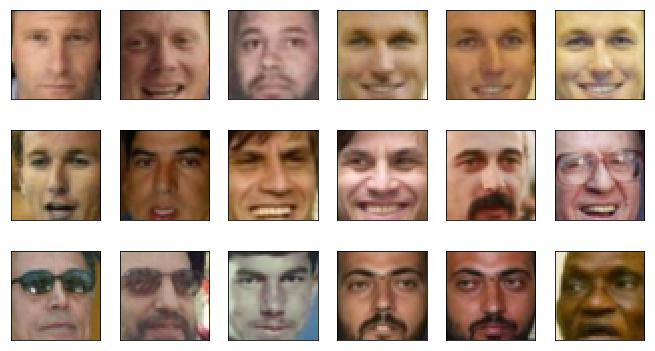

In [15]:
plot_gallery(X_train, image_h, image_w)

In [16]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

In [20]:
train[1]

(tensor([ 0.3294,  0.1804,  0.1686,  ...,  0.4196,  0.4078,  0.4863]),
 tensor(0.))

# NNs and other friends

In [22]:
input_size = 6075
hidden_size = 300
output_size = 100

encoder_net = Encoder_net(input_size = input_size, 
                          hidden_size = hidden_size, 
                          output_size = output_size)

decoder_net = Decoder_net(input_size = input_size, 
                          hidden_size = hidden_size, 
                          output_size = output_size)

In [34]:
encoder = Encoder(encoder_net, X_train)
decoder = Decoder(decoder_net)

In [35]:
opt = torch.optim.Adam(var.parameters, lr=1e-3)
svi = SVI(data, prior, var, opt)

In [36]:
svi.make_inference(num_steps=1000, shuffle=False, print_progress=True)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.